In [55]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

from nltk import bigrams
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [56]:
import torch
torch.cuda.empty_cache() 

In [57]:
bib_verses = {}

for ve in F.otype.s('verse'):
    bo, ch, v = T.sectionFromNode(ve)
    heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(ve, 'word')]).strip()
    bib_verses[(bo, ch, v)] = [bo, ch, v, heb_text]

bib_df = pd.DataFrame(bib_verses).T
bib_df.columns = ['book', 'chapter', 'verse', 'text']
bib_df.head()

book chapter verse  \
Genesis 1 1  Genesis       1     1   
          2  Genesis       1     2   
          3  Genesis       1     3   
          4  Genesis       1     4   
          5  Genesis       1     5   

                                                          text  
Genesis 1 1               בראשׁית ברא אלהים את השׁמים ואת הארץ  
          2  והארץ היתה תהו ובהו וחשׁך על פני תהום ורוח אלה...  
          3                       ויאמר אלהים יהי אור ויהי אור  
          4  וירא אלהים את האור כי טוב ויבדל אלהים בין האור...  
          5  ויקרא אלהים לאור יום ולחשׁך קרא לילה ויהי ערב ...

In [58]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

def make_n_clause_dict(n):
    n_clause_dict = {}
    #bo_ch_list = []

    for bo in F.otype.s('book'):
        cl_n_grams = list(make_n_grams(L.d(bo, 'clause'), n))
        
        for cl_n_gram in cl_n_grams:
            ch = L.u(cl_n_gram[0], 'chapter')[0]
            book, chapter_number = T.sectionFromNode(ch)
            
            words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
            n_clause_dict[(book, chapter_number, cl_n_gram)] = [book, chapter_number, cl_n_gram, heb_text]

    return n_clause_dict

n_clause_dict = make_n_clause_dict(3)

bib_df = pd.DataFrame(n_clause_dict).T
bib_df.columns = ['book', 'chapter', 'clauses', 'text']

shuffled_bib_df = bib_df.sample(n=len(bib_df), random_state=42)
shuffled_bib_df = shuffled_bib_df.reset_index(drop=True)

In [59]:
bib_ds = Dataset.from_pandas(shuffled_bib_df)

In [60]:
tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL')

In [61]:
def tokenize(sentence):
  return tokenizer(sentence['text'], max_length=128, truncation=True, padding=True)

tokenized_data = bib_ds.map(tokenize, batched=True) #, remove_columns=raw_data['train'].column_names)
tokenized_data.set_format("pt", columns=["input_ids", "attention_mask"], output_all_columns=True)

tokenized_data = tokenized_data.train_test_split(test_size=0.2)

Map:   0%|          | 0/88053 [00:00<?, ? examples/s]

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', output_hidden_states=True).to(device)

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [11]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=.15)

In [12]:
args = TrainingArguments(output_dir="martijn75/berel_finetuned_on_shuffled_HB_5_epochs_general", 
                         evaluation_strategy="steps",
                         save_strategy="epoch",
                         learning_rate=0.0001,
                         num_train_epochs=5,
                         per_device_train_batch_size=8, 
                         per_device_eval_batch_size=8,
                         seed=42,
                        )
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
  )

trainer.train()

trainer.push_to_hub()

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\geitb\AppData\Local\Temp\ipykernel_5172\1556680825.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,3.283500,2.942119
1000,3.377200,2.986623
1500,3.372700,2.925586
2000,3.220900,2.991453
2500,3.289500,2.944206
3000,3.311200,nan
3500,3.291800,nan
4000,3.372900,2.926608
4500,3.155700,2.919324
5000,3.161900,2.904570


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/martijn75/berel_finetuned_on_shuffled_HB_5_epochs_general/commit/f9d7fb94828826674919055a55adf3ca267bda00', commit_message='End of training', commit_description='', oid='f9d7fb94828826674919055a55adf3ca267bda00', pr_url=None, repo_url=RepoUrl('https://huggingface.co/martijn75/berel_finetuned_on_shuffled_HB_5_epochs_general', endpoint='https://huggingface.co', repo_type='model', repo_id='martijn75/berel_finetuned_on_shuffled_HB_5_epochs_general'), pr_revision=None, pr_num=None)

In [63]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
        }

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

jeremiah = {'Jeremiah'}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

In [64]:
bi_clause_genre_dict = {}

for bo in F.otype.s('book'):
    book = T.sectionFromNode(bo)[0]
    #if book not in genre_dict:
    #    continue
    
    cl_bigrams = list(bigrams(L.d(bo, 'clause')))

    for cl_bigram in cl_bigrams:
        words_bi_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_bigram])))
        heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_bi_clause]).strip()
        bi_clause_genre_dict[(book, cl_bigram, genre_dict.get(book))] = heb_text    

del A, F, T, L

In [65]:
len(bi_clause_genre_dict)

88092

In [66]:
def get_last_hidden_state(model, inputs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #'cpu' 
    model = model.to(device)
    outputs = model(**inputs)
    return outputs

In [67]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [68]:
heb_texts = list(n_clause_dict.values())
heb_texts_n = split_evenly(heb_texts, 1000)

In [69]:
len(heb_texts_n)

1001

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', 
                                                           ).to(device)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [73]:
hidden_states = []

for idx, texts_chunk in enumerate(heb_texts_n):
    hebrew_texts = [info_list[3] for info_list in texts_chunk]
    tokenized_inputs = tokenizer(hebrew_texts, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
    with torch.no_grad():
        outputs = get_last_hidden_state(model, tokenized_inputs)
        last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
        hidden_states.append(last_hidden_states)

['בראשׁית ברא אלהים את השׁמים ואת הארץ והארץ היתה תהו ובהו וחשׁך על פני תהום', 'והארץ היתה תהו ובהו וחשׁך על פני תהום ורוח אלהים מרחפת על פני המים', 'וחשׁך על פני תהום ורוח אלהים מרחפת על פני המים ויאמר אלהים', 'ורוח אלהים מרחפת על פני המים ויאמר אלהים יהי אור', 'ויאמר אלהים יהי אור ויהי אור', 'יהי אור ויהי אור וירא אלהים את האור', 'ויהי אור וירא אלהים את האור כי טוב', 'וירא אלהים את האור כי טוב ויבדל אלהים בין האור ובין החשׁך', 'כי טוב ויבדל אלהים בין האור ובין החשׁך ויקרא אלהים לאור יום', 'ויבדל אלהים בין האור ובין החשׁך ויקרא אלהים לאור יום ולחשׁך קרא לילה', 'ויקרא אלהים לאור יום ולחשׁך קרא לילה ויהי ערב', 'ולחשׁך קרא לילה ויהי ערב ויהי בקר', 'ויהי ערב ויהי בקר יום אחד', 'ויהי בקר יום אחד ויאמר אלהים', 'יום אחד ויאמר אלהים יהי רקיע בתוך המים', 'ויאמר אלהים יהי רקיע בתוך המים ויהי מבדיל בין מים למים', 'יהי רקיע בתוך המים ויהי מבדיל בין מים למים ויעשׂ אלהים את הרקיע', 'ויהי מבדיל בין מים למים ויעשׂ אלהים את הרקיע ויבדל בין המים ובין המים', 'ויעשׂ אלהים את הרקיע ויבדל בין המים אשׁר מתח

TypeError: 'NoneType' object is not subscriptable

In [ ]:
hidden_states_mean = []

for hs in hidden_states:

    bi_clause_states= np.mean(hs, 1)
    hidden_states_mean.append(bi_clause_states)

all_embeddings = np.concatenate(hidden_states_mean, axis=0)

In [ ]:
all_genres = []
all_labels = []

for bo, clauses, genre in bi_clause_genre_dict.keys():
    if genre == 'prose':
        all_genres.append(0)
    elif genre == 'poetry':
        all_genres.append(1)
    elif genre == 'Jeremiah':
        all_genres.append(2)

    all_labels.append((bo, clauses))

In [35]:
print(len(all_genres), len(all_embeddings))

72202 88053


In [36]:
pr_po_idx = [idx for idx, value in enumerate(all_genres) if value != 2]
y = np.array([value for idx, value in enumerate(all_genres) if value != 2])

prose_poetry_embeddings = all_embeddings[pr_po_idx,:]
jer_embeddings = np.delete(all_embeddings, pr_po_idx, axis=0)

prose_poetry_labels = [label for genre, label in zip(all_genres, all_labels) if genre != 2]

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(prose_poetry_embeddings, y, test_size=0.2)

In [39]:
X_train = pd.DataFrame(X_train)
X_train['label'] = y_train

poetry = X_train[X_train.label == 1]
print(poetry.shape)
prose = X_train[X_train.label == 0]
print(prose.shape)

(11659, 769)
(41164, 769)


In [40]:
from sklearn.utils import resample

poetry_upsample = resample(poetry,
             replace=True,
             n_samples=len(prose),
             random_state=42)

all_upsampled = pd.concat([poetry_upsample, prose])
print(all_upsampled.shape, pd.value_counts(all_upsampled.label))

X_train = all_upsampled.drop('label', axis=1)
y_train = all_upsampled['label']

C:\Users\geitb\AppData\Local\Temp\ipykernel_27444\3847905214.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(all_upsampled.shape, pd.value_counts(all_upsampled.label))


(82328, 769) label
1    41164
0    41164
Name: count, dtype: int64


In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_pred = rf.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8989095865515675


In [44]:
pd.crosstab(y_test, y_pred)

col_0,0,1
row_0,,
0,9975,310
1,1025,1896


In [43]:
jer_preds = list((rf.predict(jer_embeddings)))
#jer_preds

### PCA

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [27]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [28]:
pcs = pca_pl.fit_transform(prose_poetry_embeddings)

In [29]:
pcs

array([[ -9.648572  ,   0.48060137,   4.166947  ,   0.31995404,
          3.1252446 ,  -1.2527642 ],
       [-11.365866  ,   0.4869445 ,   5.4596167 ,  -1.4502119 ,
          4.5175414 ,  -2.6194606 ],
       [ -7.160279  ,   0.3307255 ,   7.3508153 ,   2.5368228 ,
          6.198132  ,  -2.4747431 ],
       ...,
       [ -4.7933736 ,  -5.9489408 ,   7.7963147 ,   2.4220147 ,
          0.09162114,   0.79982877],
       [ -5.5039697 ,  -2.456855  ,   4.942718  ,  -1.44711   ,
         -0.9031005 ,  -1.841409  ],
       [ -8.839165  ,   0.6263905 ,   6.3254857 ,  -1.2022891 ,
         -5.326937  ,   0.8222143 ]], dtype=float32)

In [30]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y



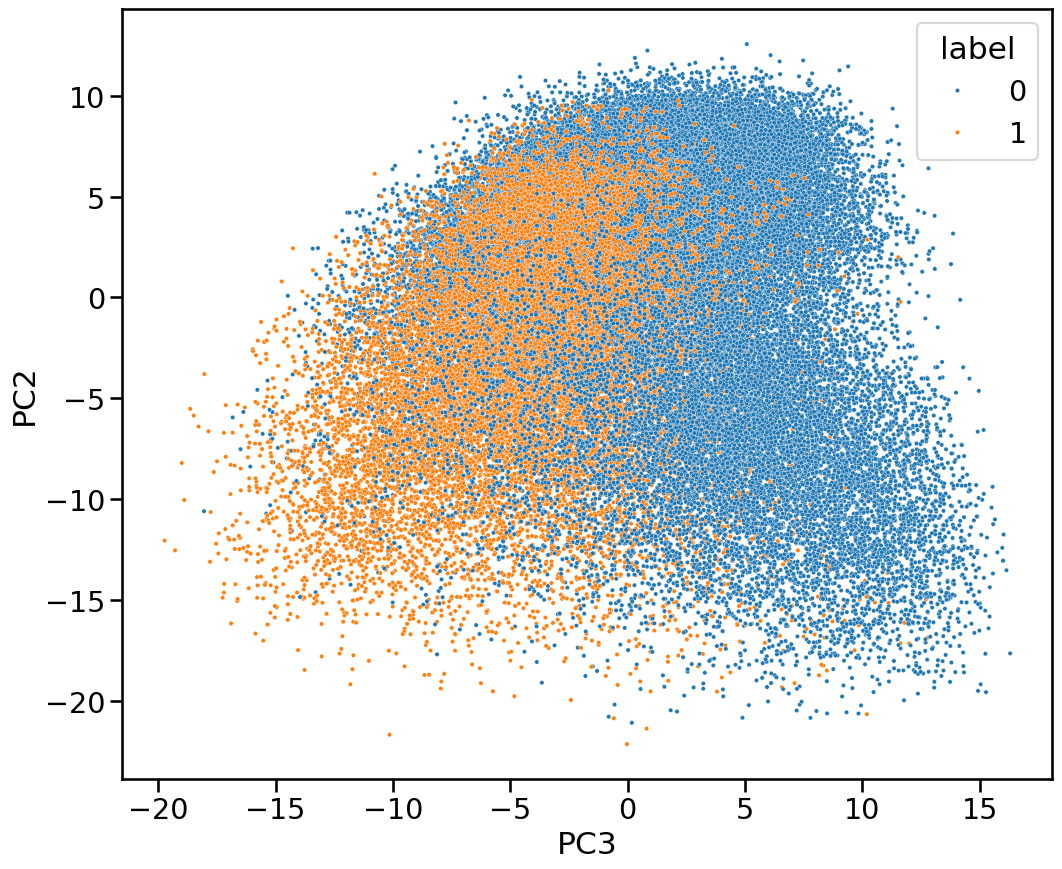

In [32]:
comp1 = 'PC1'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y
pcs_df['book'] = prose_poetry_labels

plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)

In [50]:
from sklearn.cluster import KMeans

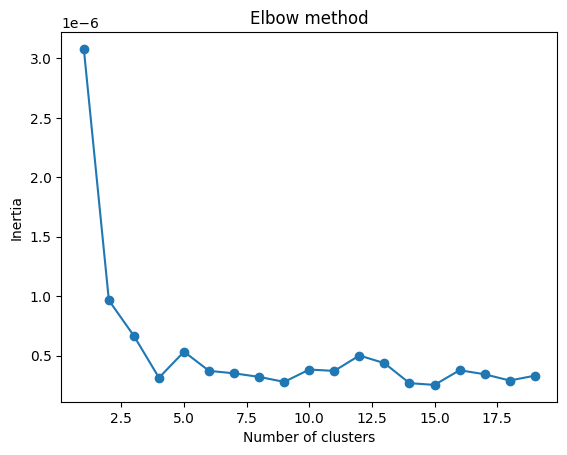

In [51]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(prose_poetry_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(prose_poetry_embeddings)

KMeans(n_clusters=4)

In [53]:
kmeans.labels_

array([3, 3, 3, ..., 2, 2, 2])

In [54]:
import collections

collections.Counter([(bo, label) for (bo, cl), label in zip(prose_poetry_labels, kmeans.labels_)])

Counter({('Psalms', 0): 5556,
         ('Genesis', 0): 2880,
         ('Job', 0): 2338,
         ('1_Samuel', 2): 2180,
         ('Proverbs', 0): 1976,
         ('Exodus', 0): 1887,
         ('Genesis', 2): 1882,
         ('1_Chronicles', 0): 1783,
         ('Psalms', 2): 1728,
         ('Deuteronomy', 0): 1626,
         ('Numbers', 0): 1622,
         ('2_Kings', 0): 1557,
         ('Joshua', 0): 1504,
         ('Exodus', 2): 1502,
         ('2_Samuel', 2): 1420,
         ('2_Samuel', 0): 1404,
         ('1_Kings', 2): 1398,
         ('2_Chronicles', 0): 1313,
         ('1_Samuel', 0): 1296,
         ('Leviticus', 0): 1209,
         ('1_Kings', 0): 1188,
         ('Deuteronomy', 2): 1152,
         ('Judges', 0): 1152,
         ('Leviticus', 2): 1080,
         ('Numbers', 1): 1014,
         ('Judges', 2): 1008,
         ('2_Chronicles', 2): 994,
         ('Genesis', 1): 936,
         ('Nehemiah', 0): 870,
         ('2_Kings', 2): 834,
         ('Daniel', 0): 827,
         ('Deuteronomy'

In [55]:
pcs_df_km = pcs_df.drop(['PC3', 'PC4','PC5','PC6','label'], axis=1)

km = KMeans(n_clusters=20)
km.fit(pcs_df_km)

ValueError: setting an array element with a sequence.

In [56]:
km_df = pd.DataFrame([(bo, label) for (bo, cl), label in zip(prose_poetry_labels, km.labels_)])
km_df.columns = ['book', 'cl']
pd.crosstab(km_df.book, km_df.cl)

AttributeError: 'KMeans' object has no attribute 'labels_'

In [57]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pcs_df_km)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

ValueError: setting an array element with a sequence.

In [45]:
dir(kmeans)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_algorithm',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params_vs_input',
 '_check_test_data',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_features_out',
 '_n_init',
 '_n_threads',
 '_parameter_constraints',
 '_re